In [67]:
from numpy import asarray
from matplotlib import pyplot
from PIL import Image

In [68]:
# https://stackoverflow.com/questions/35859140/remove-transparency-alpha-from-any-image-using-pil
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_emojis(emojis_directory, fixed_directory):
    if (not os.path.exists(fixed_directory)):
        os.makedirs(fixed_directory)
    
    emojis = list()

    files = [f for f in os.listdir(emojis_directory) if os.path.isfile(os.path.join(emojis_directory, f))]

    for filename in files:
        image = Image.open(f'{emojis_directory}/{filename}')

        # Remove the transparency from the image
        image = remove_transparency(image)
        image.save(f'{fixed_directory}/{filename}')

        # Convert the image into 'RGB' mode
        image = image.convert('RGB')

def load_emojis(directory):
    emojis = list()

    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    for filename in files:
        image = Image.open(f'{directory}/{filename}')

        # Convert the image into 'RGB' mode
        image = image.convert('RGB')
        
        pixels = asarray(image)
        emojis.append(pixels)

    return asarray(emojis)

def plot_emojis(emojis, n_cols):
    for i in range(n_cols):
        pyplot.subplot(n_cols, n_cols, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(emojis[i])
    pyplot.show()

In [73]:
dir_emojis = 'emojis'
dir_emojis_fixed = 'emojis-fixed'
preprocess_emojis(dir_emojis, dir_emojis_fixed)

Loaded:  (652, 72, 72, 3)


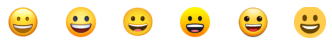

In [75]:
emojis = load_emojis(dir_emojis_fixed)
print('Loaded: ', emojis.shape)
plot_emojis(emojis, 6)